In [1]:
from dataset import *
from model import *
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
class trainfc():
    def __init__(self, in_num, out_num, layers, node_num, csv_path, batchsize, epochs):
        self.fcmodel = fcnet(in_num, out_num, layers, node_num)
        self.in_num = in_num
        self.fcmodel.train()
        self.dataset = Dataset(csv_path)
        self.batchsize = batchsize
        self.train_loader = paddle.io.DataLoader(self.dataset, batch_size=batchsize, shuffle=True)
        self.epochs = epochs
        self.losslist = []
        self.acclist = []
        model_info = paddle.summary(self.fcmodel, (1, 20))
        print(model_info)
        self.dataset.showlabel()
        
    def train(self):
        optim = paddle.optimizer.Adam(parameters=self.fcmodel.parameters())
        loss_fn = paddle.nn.MSELoss()
        acc_fn = Precision()
        with tqdm(total=self.epochs*len(self.dataset)/self.batchsize) as pbar:
            pbar.set_description('[Training] loss: nan, acc: 0.00%')
            for epoch in range(self.epochs):
                for batch_id, data in enumerate(self.train_loader()):
                    inp = data[0]
                    label = data[1]
                    predicts = self.fcmodel(inp)
                    acc_fn.update(predicts, label)
                    acc = acc_fn.accumulate()
                    acc_fn.reset()
                    loss = loss_fn(predicts, label)
                    loss.backward()
                    optim.step()
                    optim.clear_grad()
                    pbar.set_description('[Training] loss: %.2f, acc: %.2f%%' % (loss.numpy(), 100*acc))
                    pbar.update(1)
                    self.losslist.append(loss.numpy())
                    self.acclist.append(100*acc)
    
    def visualize(self, path2save):
        l = np.array(self.losslist)
        x_axis = len(l)
        step = np.linspace(1,x_axis,x_axis)
        plt.plot(step,l,label="Train Loss")
        plt.legend(loc='upper right')
        plt.title('step-loss')
        plt.xlim((0, x_axis))
        plt.ylim((0, 1))
        plt.gca().set_ylim(bottom=0)
        plt.xlabel('step')
        plt.ylabel('loss')
        plt.savefig(os.path.join(path2save, 'loss.png'), bbox_inches='tight')
        plt.show()

        a = np.array(self.acclist)
        plt.plot(step,a,label="Train Acc")
        plt.legend(loc='upper right')
        plt.title('step-acc')
        plt.xlim((0, x_axis))
        plt.ylim((0, 100))
        plt.gca().set_ylim(bottom=0)
        plt.xlabel('step')
        plt.ylabel('acc')
        plt.savefig(os.path.join(path2save,'acc.png'), bbox_inches='tight')
        plt.show()
        print("[Visualization] Done!")
    
    def save(self, path2save):
        paddle.jit.save(
            layer=self.fcmodel,
            path=os.path.join(path2save, "fcmodel"),
            input_spec=[
                paddle.static.InputSpec(shape=[1, self.in_num], dtype='float32')
                ])

        paddle.onnx.export(
            self.fcmodel, 
            os.path.join(path2save, "fcmodel"), 
            input_spec = [
                paddle.static.InputSpec(shape=[1, self.in_num], dtype='float32')
                ], opset_version=12)
        print("[Model Save] Done!")

W1226 13:44:46.481302  9982 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.5, Driver API Version: 11.7, Runtime API Version: 11.6
W1226 13:44:46.485899  9982 gpu_resources.cc:91] device: 0, cuDNN Version: 8.4.


---------------------------------------------------------------------------
 Layer (type)       Input Shape          Output Shape         Param #    
   Linear-1          [[1, 20]]            [1, 2048]           43,008     
    ReLU-1            [[1, 1]]              [1, 1]               0       
   Linear-2         [[1, 2048]]           [1, 2048]          4,196,352   
   Linear-3         [[1, 2048]]           [1, 2048]          4,196,352   
   Linear-4         [[1, 2048]]           [1, 2048]          4,196,352   
   Linear-5         [[1, 2048]]             [1, 1]             2,049     
   Sigmoid-1          [[1, 1]]              [1, 1]               0       
Total params: 12,634,113
Trainable params: 12,634,113
Non-trainable params: 0
---------------------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 48.20
Estimated Total Size (MB): 48.26
-------------------------------------------------------------

[Training] loss: 0.25, acc: 86.76%: 100%|███| 180/180.0 [00:34<00:00,  5.15it/s]


2022-12-26 13:45:22 [INFO]	Static PaddlePaddle model saved in model.save/paddle_model_static_onnx_temp_dir.
[Paddle2ONNX] Start to parse PaddlePaddle model...
[Paddle2ONNX] Model file path: model.save/paddle_model_static_onnx_temp_dir/model.pdmodel
[Paddle2ONNX] Paramters file path: model.save/paddle_model_static_onnx_temp_dir/model.pdiparams
[Paddle2ONNX] Start to parsing Paddle model...
[Paddle2ONNX] Use opset_version = 12 for ONNX export.
[Paddle2ONNX] PaddlePaddle model is exported as ONNX format now.
2022-12-26 13:45:23 [INFO]	ONNX model saved in model.save/fcmodel.onnx.
[Model Save] Done!


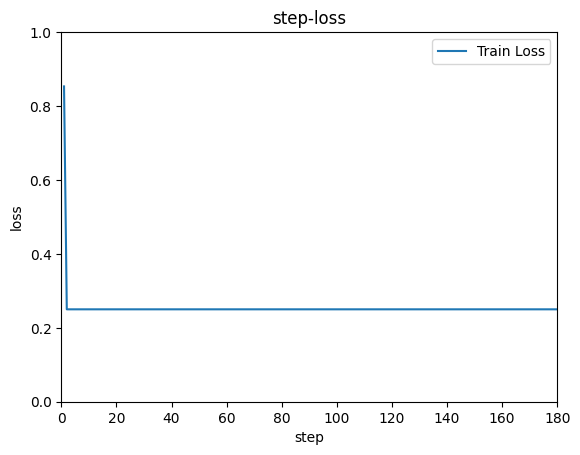

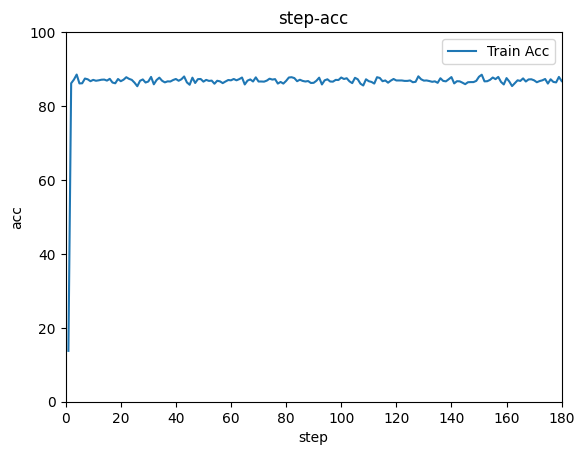

[Visualization] Done!


In [3]:
if __name__=="__main__":
    fcmodel = trainfc(20, 1, 5, 2048, "data/train.csv", 2500, 20)
    fcmodel.train()
    fcmodel.save('model.save')
    fcmodel.visualize('statics')